# Data at Scale - Executable code

## Import packages

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import pickle
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", 'This pattern has match groups')

## Import list of search words (of emerging technologies)

In [2]:
searchwords_df = pd.read_csv('Gartner_Hypecycle_cleanwiki_words.csv')

# Get unique Technologies
searchwords_df.Technology = [word.lower() for word in searchwords_df.Technology]
searchwords = searchwords_df.Technology.unique()

# to look for Titles in the Wiki dumps file, space must be an underscore
search_words = [word.replace(" ","_") for word in searchwords]

# Save to file in the current working directory
#with open('search_words', 'wb') as file:  
#     pickle.dump(search_words, file)

## Get Wikipedia Edits data

In [3]:
import pprint 
import requests

def query(request): 
    """
    Send HTTP/1.1 requests to Wikipedia for specified revisionparameter 'request'
       
    Args:
    ----------
    searchwords: list
        list of searchwords for which wikipedia edits data are queried
  
    Return:
    ---------
    dict
        of page information as specified in 'request'
    """    
    request['action'] = 'query'
    request['format'] = 'json'
    lastContinue = {}
    while True:
        # Clone original request
        req = request.copy()
        # Modify it with the values returned in the 'continue' section of the last result.
        req.update(lastContinue)
        # Call API
        result = requests.get('https://en.wikipedia.org/w/api.php', params=req).json()
        if 'error' in result:
            print(result['error'])
            #raise Error(result['error'])
        if 'warnings' in result:
            print(result['warnings'])
        if 'query' in result:
            yield result['query']
        if 'continue' not in result:
            break
        lastContinue = result['continue']

In [4]:
def query_wiki_edits(search_words, timestart, timeend):
    """
    Query Wikipedia edit data for specified revisionparameter 'request' and list of search_words
       
    Args:
    ----------
    request: dict
        dictionary of properties to query Wikipedia edits
        see https://www.mediawiki.org/wiki/API:Properties for properties to get revisions
  
    Return:
    ---------
    dataframe
        dataframe containing information on the timestamps of all edits, the editer and size (bytes) of edits
    """  
    all_edits = pd.DataFrame()
    
    # query for each search_word page information
    for i in range(len(search_words)):
        edits = pd.DataFrame(columns = ["anon","size","timestamp","user", "pageid", "page_name"])
        title = search_words[i]
        
        try:
            # try to query information for word in search_words
            # error occurs if no Wikipedia page exisits for searchwords
            revisionsparams = {'titles': title, 'prop':'revisions', 'rvprop':'timestamp|user|size', 
                               'rvstart': timeend, 'rvend': timestart, 'rvslots':'main', 'format':'json', 
                               'formatversion':'2'}
            revisionsdata = list(query(revisionsparams))
            
           
            try:
                 # get revision (edits) information and append to a dataframe    
                 # error occurs if no edits exists for a given timeframe
                for l in range(len(revisionsdata)):
                    edits_add = pd.DataFrame(revisionsdata[l]["pages"][0]["revisions"])
                    edits = edits.append(edits_add, ignore_index=True, sort = True)
            except:
                print(">>> No edits exists for:", title)
            
            # page ID is same for the same word, asign it once outside of inner loop
            pageID = revisionsdata[l]["pages"][0]["pageid"]
            edits["pageid"] = pageID
            edits["page_name"] = title
            all_edits = all_edits.append(edits, ignore_index=True, sort = True)
        except:
            print(">>> No Wikipedia page for:", title)
    return all_edits[["timestamp", "page_name", "user", "size"]]

In [64]:
%%time
all_edits = query_wiki_edits(search_words, timestart = '2001-01-15T00:00:00Z', timeend = '2018-12-22T00:00:00Z')
all_edits 

>>> No edits exists for: 3d_television
>>> No Wikipedia page for: 3d_television
CPU times: user 3min 22s, sys: 7.71 s, total: 3min 30s
Wall time: 39min 49s


In [67]:
# Save to file in the current working directory
#with open('all_wiki_edits.pkl', 'wb') as file:  
#    pickle.dump(all_edits, file)

## Get Wikipedia View data

get a list of files, each contain hourly page view informations for all Wikipedia pages

In [247]:
files_list_all = glob.glob("./data/wiki-pageview-2018-10/*.gz")

<br> run only a subset

In [248]:
with open("search_words", 'rb') as file:  
    search_words_all = pickle.load(file)
    
files_list = files_list_all[0:3]
search_words = search_words_all[0:12]

<br> Function to get views information per file

In [252]:
# get number of views per file (each file contains views of one hour)
def get_views_per_file(view_file, search_words):
    """
    Get Wikipedia page view information for a given file. 
    Files documents hourly the views
       
    Args:
    ----------
    views_file: file directory
        directory to Wikipedia page view file
    search_words: 
    
    Return:
    ---------
    dataframe
        dataframe containing information on the timestamps of all edits, the editer and size (bytes) of edits
    """  
    view = pd.read_csv(view_file, compression='gzip', header=0, sep=' ', quotechar='"')
    view.columns = ["aa","Main_Page", "Views", "Size"]
    view_en_m = view[view.aa == 'en']
    timestamp = view_file[39:54]
    df_view_per_file = pd.DataFrame(columns = ["Size","Views","Main_Page", "aa", "search_word", "timestamp"])
    not_found = []
    for word in search_words:
        try:
            index = view_en_m.Main_Page.str.contains("^"+word+"$", case = False, na = False)
            df_view_add = view_en_m[index]
            df_view_add.loc[:,"search_word"] = word
            df_view_add.loc[:,"timestamp"] = timestamp
            df_view_add.columns = ["aa", "Main_Page", "Views", "Size", "search_word", "timestamp"]
            df_view_per_file = df_view_per_file.append(df_view_add, ignore_index=True, sort = True)
        except:
            pass
    return df_view_per_file[["timestamp", "search_word", "Views"]]

# Single Processing

In [253]:
# get number of views for all files in directory (directory contains files hourly for the October 2018)
def get_views_singleprocessing(files_list,  search_words):
    """
    Get Wikipedia page view information for a a list file using a single processing approach. 
    
    Args:
    ----------
    views_file: str
        file directory to Wikipedia page view file
    searchwords: list
        list of searchwords for which wikipedia page view data are collected

    Return:
    ---------
    dataframe
        dataframe containing information on the timestamps of all edits, the editer and size (bytes) of edits
    """  
    df_views = pd.DataFrame(columns =["timestamp", "search_word", "Views"])
    for file in files_list:
        df_view_per_file = get_views_per_file(file,  search_words)
        df_views = df_views.append(df_view_per_file, ignore_index=True, sort = True)
 
    return df_views

# Multiprocessing

In [254]:
import multiprocessing
from functools import partial

def get_views_multiprocessing(files_list, search_words, cpu):
    """
    Get Wikipedia page view information for a a list file using a multiprocessing approach. 
    
    Args:
    ----------
    files_list: list
        list of file directory to Wikipedia page view files
    searchwords: list
        list of searchwords for which wikipedia page view data are collected
    cpu: int
        number of CPUs to user for the multiprocessing approach
        
    Return:
    ---------
    dataframe
        dataframe containing information on the timestamps of all edits, the editer and size (bytes) of edits
    """   
    df_views = pd.DataFrame(columns = ["timestamp", "search_word", "Views"])
    
    # distribute files in files_list on multi processes and not search_words
    # -> set search_words as constant value
    get_views_per_file_partial = partial(get_views_per_file, search_words = search_words)
    
    # start multiprocessing
    with multiprocessing.Pool(cpu) as pool:
        results = pool.map(get_views_per_file_partial, files_list)
       
    for r in results:
        df_views = df_views.append(r, ignore_index=True, sort = True)
  
    return df_views

## Testing Functions, compare all outputs

Testing functions to compare if output of single and multi processing are equal

In [16]:
def singe_equal_multiprocessing(file_list_test, search_words_test):
    """
    Run and compare outpit of get_views_singleprocessing() and get_views_multiprocessing()
    
    Args:
    ----------
    file_list_test: list
        list of file directory to Wikipedia page view files
    search_words_test: list
        list of searchwords for which wikipedia page view data are collected
        
    Return:
    ---------
    dataframes
        two dataframe resulting from get_views_singleprocessing() and get_views_multiprocessing()
    """  
        
    result_single = get_views_singleprocessing(files_list_test,  search_words_test)
    result_multi = get_views_multiprocessing(files_list_test,  search_words_test, cpu = 3)
    
    assert result_single.equals(result_multi), "results of single and multi are not the same"
    return result_single, result_multi


files_list_test = ['./data/wiki-pageview-2018-10/pageviews-20181001-220000.gz', './data/wiki-pageview-2018-10/pageviews-20181001-230000.gz', './data/wiki-pageview-2018-10/pageviews-20181002-220000.gz']
search_words_test = ['quantum_computing', 'human_enhancement', 'biotechnology', 'audio_mining', 'flying_car', 'brain-computer_interface']
a,b = singe_equal_multiprocessing(files_list_test, search_words_test)


## Benchmark Times - Singleprocessing

In [11]:
%%time
views_test = get_views_singleprocessing(files_list, search_words_all)

CPU times: user 2min 56s, sys: 3.48 s, total: 3min
Wall time: 2min 58s


In [255]:
#Using Jupyter magic
%load_ext line_profiler
%lprun -f get_views_singleprocessing get_views_singleprocessing(files_list = files_list, search_words = search_words_all)

Timer unit: 1e-06 s

Total time: 257.932 s
File: <ipython-input-253-de607230d638>
Function: get_views_singleprocessing at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def get_views_singleprocessing(files_list,  search_words):
     3                                               
     4         1       6715.0   6715.0      0.0      df_views = pd.DataFrame(columns =["timestamp", "search_word", "Views"])
     5         4          7.0      1.8      0.0      for file in files_list:
     6         3  257919450.0 85973150.0    100.0          df_view_per_file = get_views_per_file(file,  search_words)
     7         3       5837.0   1945.7      0.0          df_views = df_views.append(df_view_per_file, ignore_index=True, sort = True)
     8                                            
     9         1          1.0      1.0      0.0      return df_views

Bottelneck is when calling the function get_view_per_file() -> parallel that

In [260]:
%load_ext memory_profiler
%memit get_views_singleprocessing(files_list = files_list, search_words = search_words_all)

peak memory: 1330.33 MiB, increment: 1161.95 MiB


<br> To memory profile singleprocesing and and get a graphic showing runtime vs memory usage the following script is run on the server using the terminal command <br>

mprof run --include-children --multiprocess memory_single_6file.py <br>
to run the profiling <bt>

mprof plot -o image.png --backend agg <br>
to save the plot to the working directory
    
this script is changes several times (such as different number of files or cpu)

In [261]:
%%file memory_single_6files.py 
from memory_profiler import profile
import time
import matplotlib

@profile(precision=4)
def get_views_singleprocessing(files_list,  search_words):
    """
    Get Wikipedia page view information for a a list file using a single processing approach. 
    
    Args:
    ----------
    views_file: str
        file directory to Wikipedia page view file
    searchwords: list
        list of searchwords for which wikipedia page view data are collected

    Return:
    ---------
    dataframe
        dataframe containing information on the timestamps of all edits, the editer and size (bytes) of edits
    """  
    
    df_views = pd.DataFrame(columns =["timestamp", "search_word", "Views"])
    for file in files_list:
        df_view_per_file = get_views_per_file(file,  search_words)
        df_views = df_views.append(df_view_per_file, ignore_index=True, sort = True)
 
    return df_views

def get_views_per_file(view_file, search_words):
    """
    Get Wikipedia page view information for a given file. 
    Files documents hourly the views
       
    Args:
    ----------
    views_file: file directory
        directory to Wikipedia page view file
    search_words: 
    
    Return:
    ---------
    dataframe
        dataframe containing information on the timestamps of all edits, the editer and size (bytes) of edits
    """  
    view = pd.read_csv(view_file, compression='gzip', header=0, sep=' ', quotechar='"')
    view.columns = ["aa","Main_Page", "Views", "Size"]
    view_en_m = view[view.aa == 'en']
    timestamp = view_file[39:54]
    df_view_per_file = pd.DataFrame(columns = ["Size","Views","Main_Page", "aa", "search_word", "timestamp"])
    not_found = []
    for word in search_words:
        try:
            index = view_en_m.Main_Page.str.contains("^"+word+"$", case = False, na = False)
            df_view_add = view_en_m[index]
            df_view_add.loc[:,"search_word"] = word
            df_view_add.loc[:,"timestamp"] = timestamp
            df_view_add.columns = ["aa", "Main_Page", "Views", "Size", "search_word", "timestamp"]
            df_view_per_file = df_view_per_file.append(df_view_add, ignore_index=True, sort = True)
        except:
            pass
    return df_view_per_file[["timestamp", "search_word", "Views"]]

import pandas as pd
import numpy as np
import os
import glob
import pickle
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", 'This pattern has match groups')

files_list_all = glob.glob("/data/wiki-pageview-2018-10/*.gz")

with open("search_words", 'rb') as file:  
    search_words_all = pickle.load(file)
    
files_list = files_list_all[0:6]
search_words = search_words_all[0:12]

res = get_views_singleprocessing(files_list = files_list, search_words = search_words)

Overwriting memory_single_6files.py


## Benchmark Times - Muliprocessing

In [42]:
%%time
views_test = get_views_multiprocessing(files_list, search_words_all, cpu = 4)

CPU times: user 47.7 ms, sys: 66.8 ms, total: 114 ms
Wall time: 1min 7s


In [43]:
#Using Jupyter magic
%load_ext line_profiler
%lprun -f get_views_multiprocessing get_views_multiprocessing(files_list = files_list, search_words = search_words_all, cpu = 4)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-06 s

Total time: 86.7271 s
File: <ipython-input-15-fbf1906079d0>
Function: get_views_multiprocessing at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def get_views_multiprocessing(files_list, search_words, cpu):
     5                                           
     6         1       5479.0   5479.0      0.0      df_views = pd.DataFrame(columns = ["timestamp", "search_word", "Views"])
     7                                               
     8                                               # distribute files in files_list on multi processes and not search_words
     9                                               # -> set search_words as constant value
    10         1          6.0      6.0      0.0      get_views_per_file_partial = partial(get_views_per_file, search_words = search_words)
    11                                               
    12                                               # s

<br> To memory profile singleprocesing and and get a graphic showing runtime vs memory usage the following script is run on the server using the terminal command <br>

mprof run --include-children --multiprocess memory_single_6file.py <br>
to run the profiling <bt>

mprof plot -o image.png --backend agg <br>
to save the plot to the working directory <br>
   
this script is changes several times (such as different number of files or cpu)

In [267]:
%%file memory_multi_6cpu_6files.py 
from memory_profiler import profile
import time
import pandas as pd
import numpy as np
import os
import glob
import pickle    
import multiprocessing
from functools import partial
import sys
import matplotlib
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", 'This pattern has match groups')
   
@profile  
def get_views_multiprocessing(files_list, search_words, cpu):
    """
    Get Wikipedia page view information for a a list file using a multiprocessing approach. 
    
    Args:
    ----------
    files_list: list
        list of file directory to Wikipedia page view files
    searchwords: list
        list of searchwords for which wikipedia page view data are collected
    cpu: int
        number of CPUs to user for the multiprocessing approach
        
    Return:
    ---------
    dataframe
        dataframe containing information on the timestamps of all edits, the editer and size (bytes) of edits
    """  
     
    df_views = pd.DataFrame(columns = ["timestamp", "search_word", "Views"])
    
    # distribute files in files_list on multi processes and not search_words
    # -> set search_words as constant value
    get_views_per_file_partial = partial(get_views_per_file, search_words = search_words)
    
    # start multiprocessing
    with multiprocessing.Pool(cpu) as pool:
        results = pool.map(get_views_per_file_partial, files_list)
       
    for r in results:
        df_views = df_views.append(r, ignore_index=True, sort = True)
  
    return df_views



def get_views_per_file(view_file, search_words):
    """
    Get Wikipedia page view information for a given file. 
    Files documents hourly the views
       
    Args:
    ----------
    views_file: file directory
        directory to Wikipedia page view file
    search_words: 
    
    Return:
    ---------
    dataframe
        dataframe containing information on the timestamps of all edits, the editer and size (bytes) of edits
    """  
    view = pd.read_csv(view_file, compression='gzip', header=0, sep=' ', quotechar='"')
    view.columns = ["aa","Main_Page", "Views", "Size"]
    view_en_m = view[view.aa == 'en']
    timestamp = view_file[38:53]
    df_view_per_file = pd.DataFrame(columns = ["Size","Views","Main_Page", "aa", "search_word", "timestamp"])
    not_found = []
    for word in search_words:
        try:
            index = view_en_m.Main_Page.str.contains("^"+word+"$", case = False, na = False)
            df_view_add = view_en_m[index]
            df_view_add.loc[:,"search_word"] = word
            df_view_add.loc[:,"timestamp"] = timestamp
            df_view_add.columns = ["aa", "Main_Page", "Views", "Size", "search_word", "timestamp"]
            df_view_per_file = df_view_per_file.append(df_view_add, ignore_index=True, sort = True)

        except:
            pass
    return df_view_per_file[["timestamp", "search_word", "Views"]]



#####################################################################################################

with open("search_words", 'rb') as file:  
    search_words_all = pickle.load(file)


files_list_all = glob.glob("/data/wiki-pageview-2018-10/*.gz")

files_list = files_list_all[0:6]
search_words = search_words_all[0:12]


# Use following command if you want to loop through different datasize
#files_list = glob.glob("/data/wiki-pageview-2018-10/*.gz")[0:int(sys.argv[1])]


results = get_views_multiprocessing(files_list = files_list, search_words = search_words, cpu = 6)

Overwriting memory_multi_6cpu_6files.py


## Create Scripts to run on the Server to analyse CPU

<br> The command in the terminal to to run the function of intereset and save the time in a text file is e.g.

<br> The command in the terminal to to run the function of intereset with different parameters (here: number of CPU) and save in each loop the time in a text file is e.g.

### Script for running mulitprocessing

- Adapt parameter (CPU or datasize) for different tests
- adapt function call get_views() or get_views_multiprocessing()
- sys.argv[1] is calling the parameter $f in the terminal command

In [11]:
%%file py_get_views_multi_8cpu_all_data.py 
import pandas as pd
import numpy as np
import os
import glob
import pickle
import multiprocessing
from functools import partial
import sys
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", 'This pattern has match groups')
   
    
def get_views_singleprocessing(files_list,  search_words):
    """
    Get Wikipedia page view information for a a list file using a single processing approach. 
    
    Args:
    ----------
    views_file: str
        file directory to Wikipedia page view file
    searchwords: list
        list of searchwords for which wikipedia page view data are collected

    Return:
    ---------
    dataframe
        dataframe containing information on the timestamps of all edits, the editer and size (bytes) of edits
    """  
    
    df_views = pd.DataFrame(columns =["timestamp", "search_word", "Views"])
    for file in files_list:
        df_view_per_file = get_views_per_file(file,  search_words)
        df_views = df_views.append(df_view_per_file, ignore_index=True, sort = True)
    
    return df_views



def get_views_multiprocessing(files_list, search_words, cpu):
    """
    Get Wikipedia page view information for a a list file using a multiprocessing approach. 
    
    Args:
    ----------
    files_list: list
        list of file directory to Wikipedia page view files
    searchwords: list
        list of searchwords for which wikipedia page view data are collected
    cpu: int
        number of CPUs to user for the multiprocessing approach
        
    Return:
    ---------
    dataframe
        dataframe containing information on the timestamps of all edits, the editer and size (bytes) of edits
    """  
     
    df_views = pd.DataFrame(columns = ["timestamp", "search_word", "Views"])
    
    # distribute files in files_list on multi processes and not search_words
    # -> set search_words as constant value
    get_views_per_file_partial = partial(get_views_per_file, search_words = search_words)
    
    # start multiprocessing
    with multiprocessing.Pool(cpu) as pool:
        results = pool.map(get_views_per_file_partial, files_list)
       
    for r in results:
        df_views = df_views.append(r, ignore_index=True, sort = True)
  
    return df_views



def get_views_per_file(view_file, search_words):
    """
    Get Wikipedia page view information for a given file. 
    Files documents hourly the views
       
    Args:
    ----------
    views_file: file directory
        directory to Wikipedia page view file
    search_words: 
    
    Return:
    ---------
    dataframe
        dataframe containing information on the timestamps of all edits, the editer and size (bytes) of edits
    """  
    view = pd.read_csv(view_file, compression='gzip', header=0, sep=' ', quotechar='"')
    view.columns = ["aa","Main_Page", "Views", "Size"]
    view_en_m = view[view.aa == 'en']
    timestamp = view_file[38:53]
    df_view_per_file = pd.DataFrame(columns = ["Size","Views","Main_Page", "aa", "search_word", "timestamp"])
    not_found = []
    for word in search_words:
        try:
            index = view_en_m.Main_Page.str.contains("^"+word+"$", case = False, na = False)
            df_view_add = view_en_m[index]
            df_view_add.loc[:,"search_word"] = word
            df_view_add.loc[:,"timestamp"] = timestamp
            df_view_add.columns = ["aa", "Main_Page", "Views", "Size", "search_word", "timestamp"]
            df_view_per_file = df_view_per_file.append(df_view_add, ignore_index=True, sort = True)

        except:
            pass
    return df_view_per_file[["timestamp", "search_word", "Views"]]



#####################################################################################################
with open("search_words", 'rb') as file:  
    search_words = pickle.load(file)
        
files_list = glob.glob("/data/wiki-pageview-2018-10/*.gz")

# Use following command if you want to loop through different datasize
#files_list = glob.glob("/data/wiki-pageview-2018-10/*.gz")[0:int(sys.argv[1])]


results = get_views_multiprocessing(files_list = files_list, search_words = search_words, cpu = 8)

# Save to file in the current working directory
with open("wiki_views_multi_cpu_all.pkl", 'wb') as file:  
     pickle.dump(results, file)

Writing py_get_views_multi_8cpu_all_data.py


# Visualise Results

To visualise the runtimes, they need to be extracted first from the text files returned by the sever.

In [43]:
import pandas as pd
import numpy as np
import glob
import re

df_times = pd.DataFrame(columns = ['test','group','cpu','datasize','real', 'user', 'sys'])

def get_times(file_text):
    """
    Parse through a list of text files extracting real, user and sys times and save them in a dataframe
    
    Args:
    ----------
    files_test: list
        list of directory of the text files to be parsed
        
    Return:
    ---------
    dataframe
        dataframe containing information about which test was carried out, which group, number of CPU, datasize and real, user and sys time
    """  
    
    df_times = pd.DataFrame(columns = ['test','group','cpu','datasize','real', 'user', 'sys'])
    
    # extract information from file name
    regex_get_datasize = "(?<=datasize)(.*)(?=.text)"
    try:
        # for file pattern: time_pool_12cpu_datasize1.text
        datasize = re.search(regex_get_datasize, file_text).group(1)
        regex_group = "(?<=pool\_)(.*)(?=\_datasize)"
        
        try: 
            # for file pattern: time_pool_single_datasize1.text
            regex_get_cpu = "(?<=pool\_)(.*)(?=cpu)"
            cpu = re.search(regex_get_cpu, file_text).group(1)
            test = "varying datasize, fix cpu"
        except:
            cpu = 1
            test = "varying datasize, single processing"
            
    except:
        # for file pattern: time_pool_cpu10.text
        datasize = "48"
        test = "varying cpu"
        regex_get_cpu = "(?<=pool\_cpu)(.*)(?=.text)"
        cpu = re.search(regex_get_cpu, file_text).group(1)
        regex_group = "(?<=time\_pool\_)(.*)(?=.text)"
         
    group = re.search(regex_group, file_text).group(1)
    
    
    # extract information from file content
    file = open(file_text, "r") 
    file_times = file.read()

    regex_real = "(?<=\\nreal\\t)(.*)(?=\\nuser)"
    regex_user = "(?<=\\nuser\\t)(.*)(?=\\nsys)"
    regex_sys = "(?<=\\nsys\\t)(.*)(?=\\n)"


    real_time = re.search(regex_real, file_times).group(1)
    user_time = re.search(regex_user, file_times).group(1)
    sys_time = re.search(regex_sys, file_times).group(1)
    
    df_times = pd.DataFrame(data = {'test':[test], 'group':[group], 'cpu':[int(cpu)], 
                                    'datasize':[int(datasize)], 'real':[real_time], 
                                    'user': [user_time], 'sys': [sys_time]})
    return df_times



def convert_time(series_time):
    """
   Convert time format such as 1m1.4s, into sortable times format 61.4s
    
    Args:
    ----------
    series_time: series
        series containing time to be converted
        
    Return:
    ---------
    series
        series of converted times
    """  
    tmp = series_time.str.replace("s","")
    mi,se = tmp.str.split("m").str
    time_converted = np.round((mi.astype('float')*60 + se.astype('float'))/60, 4)
    return time_converted

In [311]:
# List of dictionary of all the text files to be parse
text_files = glob.glob("./CPU_server/*.text")
text_files.extend(glob.glob("./DataSize/CPU2/*.text"))
text_files.extend(glob.glob("./DataSize/CPU4/*.text"))
text_files.extend(glob.glob("./DataSize/CPU8/*.text"))
text_files.extend(glob.glob("./DataSize/CPU12/*.text"))
text_files.extend(glob.glob("./DataSize/CPU16/*.text"))
text_files.extend(glob.glob("./DataSize/CPU20/*.text"))
text_files.extend(glob.glob("./DataSize/CPU24/*.text"))
text_files.extend(glob.glob("./DataSize/Single/*.text"))


# get times and convert them
df_times = pd.DataFrame(columns = ['test','group','cpu','datasize','real', 'user', 'sys'])
for onefile in text_files:
    df_time = get_times(onefile)
    df_times = df_times.append(df_time)

df_times["real"] = convert_time(df_times["real"])
df_times["user"] = convert_time(df_times["user"])
df_times["sys"] = convert_time(df_times["sys"])
df_times["user+sys"] = df_times.user + df_times.sys

table_times_all  = df_times
#table_times_all.to_csv("./Results/table_times_all.csv")

In [24]:
table_times_all = pd.read_csv("./Results/table_times_all.csv")

### datasize - time - singelprocessing

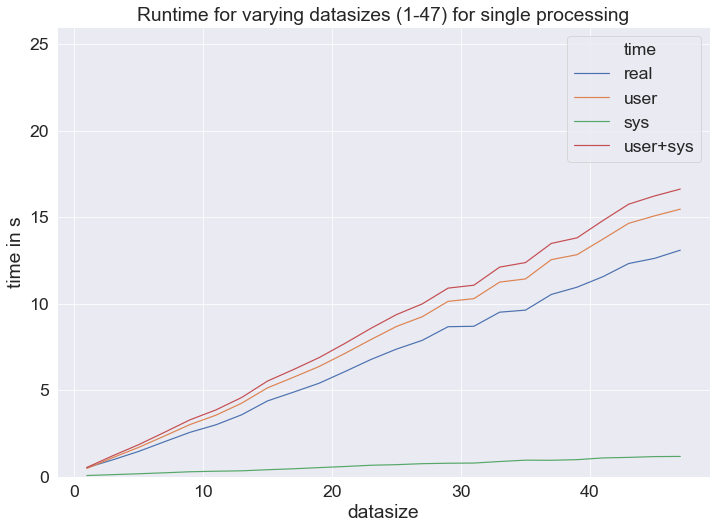

In [27]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

df_subset = table_times_all[table_times_all.test == 'varying datasize, single processing']
df_subset = df_subset.sort_values('datasize')
df_subset = df_subset[["datasize","real","user","sys","user+sys"]]
df_subset = df_subset.melt('datasize', var_name='time',  value_name='vals')

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("paper", font_scale=2) 
g = sns.lineplot(x="datasize", y="vals", hue='time', data=df_subset)
g.set(ylabel='time in s')
#g.fig.suptitle('Runtime for varying number of CPUs (2-24) and 48 files')
g.set_title('Runtime for varying datasizes (1-47) for single processing')
g.set(ylim=(0, 26))
plt.savefig('datasize_time_single.png')
plt.show()

### cpu - time - multiprocessing

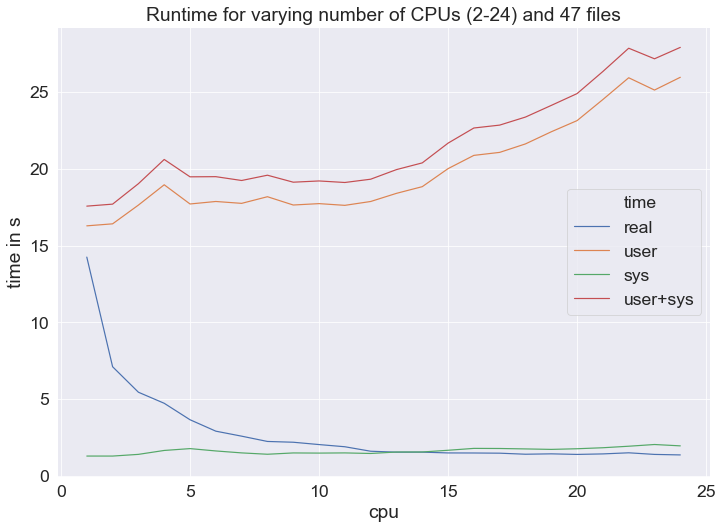

In [20]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

df_subset = table_times_all[table_times_all.test == 'varying cpu']
df_subset = df_subset.sort_values('cpu')
df_subset = df_subset[["cpu","real","user","sys","user+sys"]]
df_subset = df_subset.melt('cpu', var_name='time',  value_name='vals')

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("paper", font_scale=2) 
g = sns.lineplot(x="cpu", y="vals", hue='time', data=df_subset)
g.set(ylabel='time in s')
g.set_title('Runtime for varying number of CPUs (2-24) and 47 files')
plt.savefig('cpu_time_multi.png')
plt.show()

### datasize - time - cpu - mulitprocessing

/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


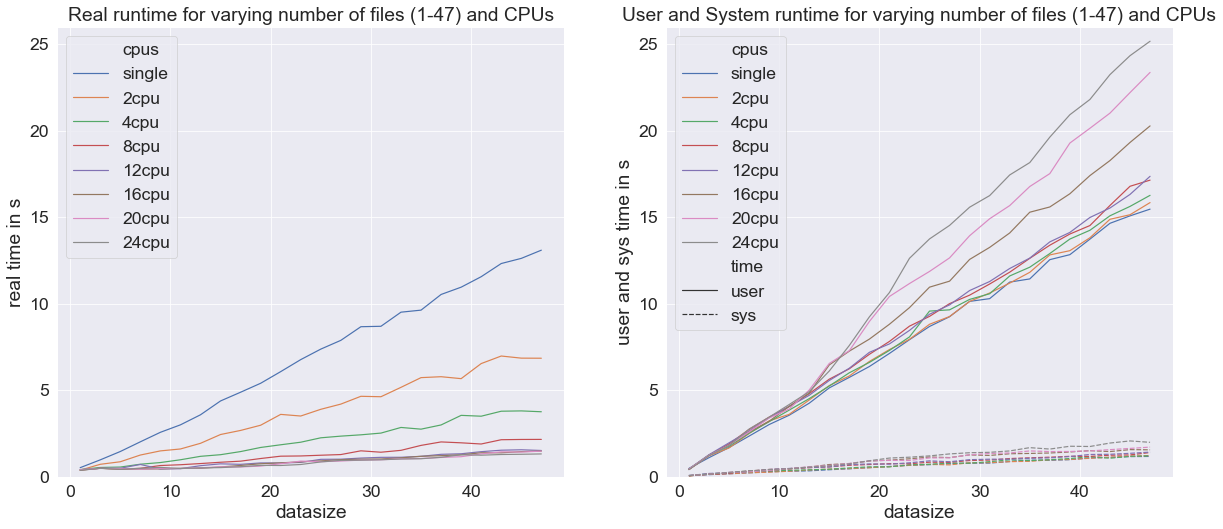

In [17]:
index1 = table_times_all.test == 'varying datasize, fix cpu'
index2 = table_times_all.test == 'varying datasize, single processing'
index = index1+index2
df_subset = table_times_all[index]
df_subset = df_subset.sort_values(['cpu','datasize'])
df_subset = df_subset[["datasize","real","group"]]
df_subset.columns = ["datasize","real","cpus"]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (20,8.27))
#sns.set(rc={'figure.figsize':(11.7,8.27)})

g = sns.lineplot(x="datasize", y="real", hue='cpus', data=df_subset, ax=ax1)
#g.set_context("paper", font_scale=2) 
g.set(ylabel='real time in s')
g.set(ylim=(0, 26))
g.set_title('Real runtime for varying number of files (1-47) and CPUs')
#plt.savefig('datasize_realtime_multi_cpu.png')
#plt.show()


index1 = table_times_all.test == 'varying datasize, fix cpu'
index2 = table_times_all.test == 'varying datasize, single processing'
index = index1+index2
df_subset = table_times_all[index]
df_subset = df_subset.sort_values(['cpu','datasize'])
df_subset = df_subset[["datasize","user","sys","group"]]
df_subset.columns = ["datasize","user","sys","cpus"]
df_subset = df_subset.melt(id_vars = ["cpus","datasize"], value_vars = ["user","sys"], var_name = "time")


#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set_context("paper", font_scale=2) 
g1 = sns.lineplot(x="datasize", y="value", hue='cpus', style = "time",data=df_subset, ax=ax2)
#g1.set_context("paper", font_scale=2) 
g1.set(ylabel='user and sys time in s')
g1.set_title('User and System runtime for varying number of files (1-47) and CPUs')
g1.set(ylim=(0, 26))
plt.savefig('datasize_interaction_multi_cpu.png')
plt.show()



### datasize - real time - multiprocessing

/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


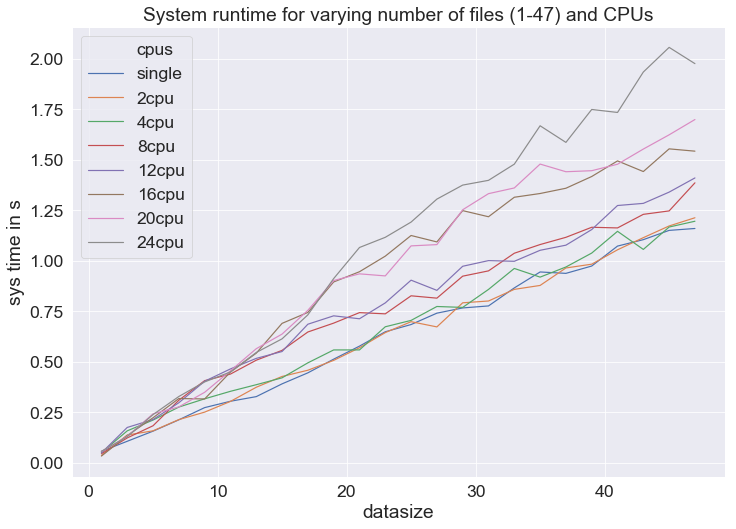

In [28]:
index1 = table_times_all.test == 'varying datasize, fix cpu'
index2 = table_times_all.test == 'varying datasize, single processing'
index = index1+index2
df_subset = table_times_all[index]
df_subset = df_subset.sort_values(['cpu','datasize'])
df_subset = df_subset[["datasize","sys","group"]]
df_subset.columns = ["datasize","sys","cpus"]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("paper", font_scale=2) 
g = sns.lineplot(x="datasize", y="sys", hue='cpus', data=df_subset)
g.set(ylabel='sys time in s')
g.set_title('System runtime for varying number of files (1-47) and CPUs')
plt.savefig('datasize_systime_multi_cpu.png')
plt.show()

### datasize - cpu times - multiprocessing

/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


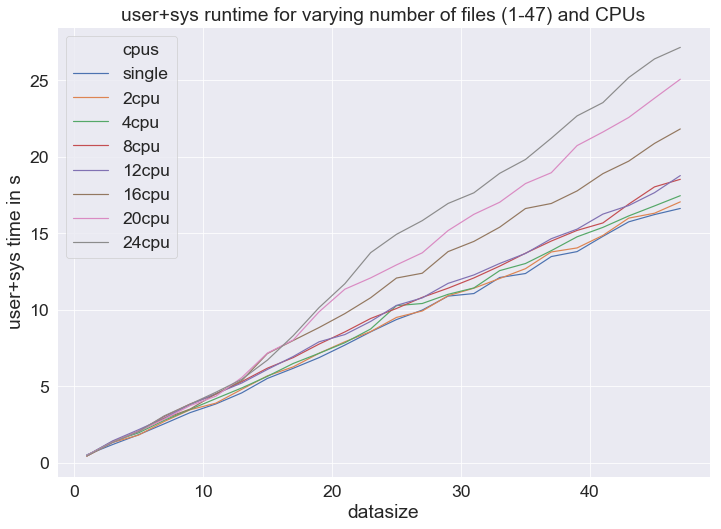

In [29]:
index1 = table_times_all.test == 'varying datasize, fix cpu'
index2 = table_times_all.test == 'varying datasize, single processing'
index = index1+index2
df_subset = table_times_all[index]
df_subset = df_subset.sort_values(['cpu','datasize'])
df_subset = df_subset[["datasize","user+sys","group"]]
df_subset.columns = ["datasize","user+sys","cpus"]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("paper", font_scale=2) 
g = sns.lineplot(x="datasize", y="user+sys", hue='cpus', data=df_subset)
g.set(ylabel='user+sys time in s')
g.set_title('user+sys runtime for varying number of files (1-47) and CPUs')
plt.savefig('datasize_usersystime_multi_cpu.png')
plt.show()

### datasize - "(user+sys)-real" time - multiprocessing

/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


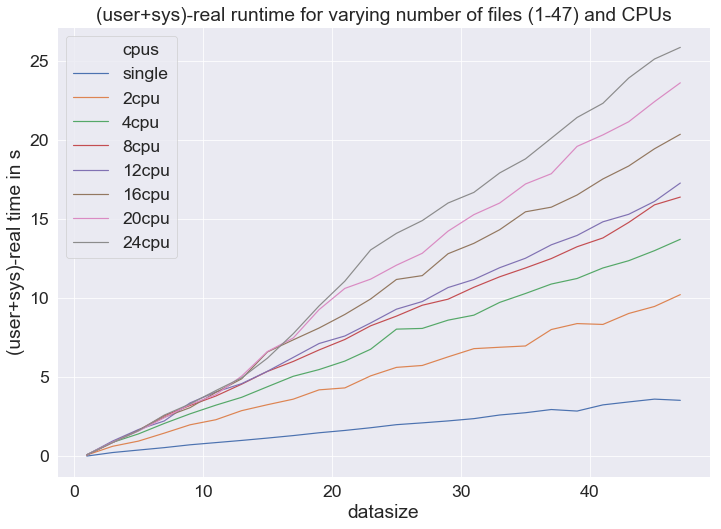

In [30]:
index1 = table_times_all.test == 'varying datasize, fix cpu'
index2 = table_times_all.test == 'varying datasize, single processing'
index = index1+index2
df_subset = table_times_all[index]
df_subset = df_subset.sort_values(['cpu','datasize'])
df_subset["(user+sys)-real"] = df_subset["user+sys"]-df_subset["real"]
df_subset = df_subset[["datasize","(user+sys)-real","group"]]
df_subset.columns = ["datasize","(user+sys)-real","cpus"]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("paper", font_scale=2) 
g = sns.lineplot(x="datasize", y="(user+sys)-real", hue='cpus', data=df_subset)
g.set(ylabel='(user+sys)-real time in s')
g.set_title('(user+sys)-real runtime for varying number of files (1-47) and CPUs')
plt.savefig('datasize_timediff_multi_cpu.png')
plt.show()

In [68]:
index1 = table_times_all.test == 'varying datasize, fix cpu'
index2 = table_times_all.test == 'varying datasize, single processing'
df_subset_multi = table_times_all[index1]
df_subset_single = table_times_all[index2]
df_subset_multi = df_subset_multi.sort_values(['datasize','cpu'])
df_subset_single = df_subset_single.sort_values(['datasize','cpu'])
df_subset_real = pd.merge(df_subset_multi, df_subset_single, on='datasize')
df_subset_real["real_ratio"] = df_subset_real["real_y"]/df_subset_real["real_x"]
df_subset_real.head()

,Unnamed: 0_x,test_x,group_x,cpu_x,datasize,real_x,user_x,sys_x,user+sys_x,Unnamed: 0_y,test_y,group_y,cpu_y,real_y,user_y,sys_y,user+sys_y,real_ratio
0,0,"varying datasize, fix cpu",2cpu,2,1,0.3668,0.4057,0.0371,0.4428,0,"varying datasize, single processing",single,1,0.5107,0.4635,0.0577,0.5212,1.392312
1,0,"varying datasize, fix cpu",4cpu,4,1,0.3999,0.4404,0.0510,0.4914,0,"varying datasize, single processing",single,1,0.5107,0.4635,0.0577,0.5212,1.277069
2,0,"varying datasize, fix cpu",8cpu,8,1,0.3754,0.4071,0.0458,0.4529,0,"varying datasize, single processing",single,1,0.5107,0.4635,0.0577,0.5212,1.360416
3,0,"varying datasize, fix cpu",12cpu,12,1,0.3913,0.4289,0.0498,0.4787,0,"varying datasize, single processing",single,1,0.5107,0.4635,0.0577,0.5212,1.305137
4,0,"varying datasize, fix cpu",16cpu,16,1,0.3597,0.4091,0.0342,0.4433,0,"varying datasize, single processing",single,1,0.5107,0.4635,0.0577,0.5212,1.419794


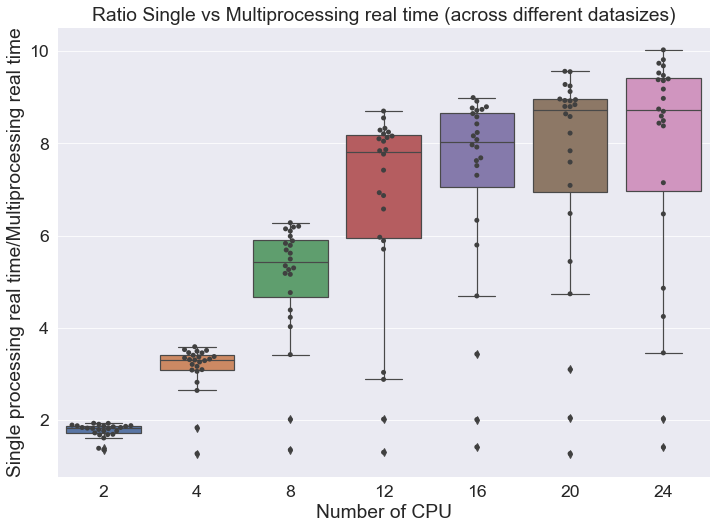

In [78]:
ax = sns.boxplot(y="real_ratio", x="cpu_x", data=df_subset_real).set_title('Ratio Single vs Multiprocessing real time (across different datasizes)')
ax = sns.swarmplot(y="real_ratio", x="cpu_x", data=df_subset_real, color=".25")
ax.set(xlabel='Number of CPU',ylabel='Single processing real time/Multiprocessing real time')
plt.savefig('boxplot_speedup.png')

## Scaling up to all Wikipedia views of October 2018

In [269]:
file = open("./Results/All_files_8CPU_180131/time_pool_get_views_multi_8cpu_all_data.text", "r") 
file_times_all = file.read()
print("Loop through all 744 data files for October 2018 using 8 CPUs:",file_times_all)

Loop through all 744 data files for October 2018 using 8 CPUs: 
real	119m49.477s
user	910m2.995s
sys	25m5.673s

